In [2]:
print("hello")
      

hello


In [3]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Oculus@100',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Saksham/Downloads/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(host = "localhost",
                            user = "root",
                            password = "Oculus@100",
                            database = "ecommerce")

cur = db.cursor()
                            

In [29]:
# List all unique cities where customers are located.

query = """ select distinct customer_city from customers """

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [15]:
# Count the number of orders placed in 2017.

query = """ select count(order_id) from  orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data= cur.fetchall()

"total orders placed in 2017 are", data[0][0]



('total orders placed in 2017 are', 90202)

In [20]:
# Find the total sales per category

query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id= order_items.order_id
group by category

"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns= ["Category","Sales"])
df

,Category,Sales
0,perfumery,2026954.64
1,Furniture Decoration,5720705.57
2,telephony,1947528.20
3,bed table bath,6850214.68
4,automotive,3409177.32
...,...,...
69,cds music dvds,4797.72
70,La Cuisine,11654.12
71,Fashion Children's Clothing,3142.68
72,PC Gamer,8697.72


In [22]:
#Calculate the percentage of orders that were paid in installments.

query = """ select (sum(case when payment_installments >=1 then 1
else 0  end))/ count(*) * 100 from payments """

cur.execute(query)

data= cur.fetchall()

data

[(Decimal('99.9981'),)]

In [ ]:
#Count the number of customers from each state.

query = """ select customer_state,count(customer_id) 
from customers group by customer_state"""

cur.execute(query)

data= cur.fetchall()

df= pd.DataFrame(data, columns = ["state", "customer_count"])
plt.figure(figsize = (8,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()


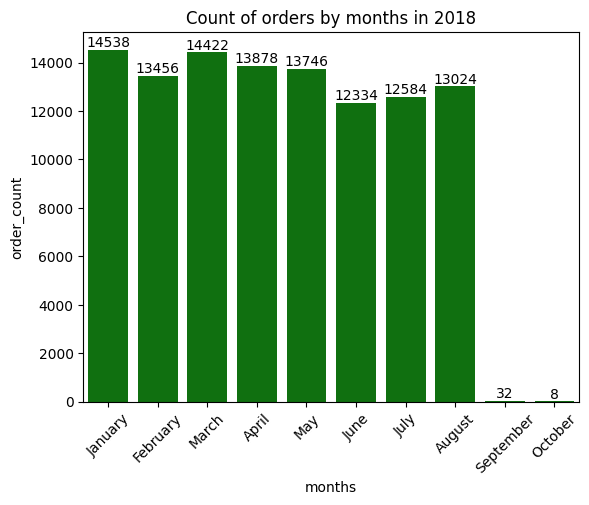

In [39]:
#Calculate the number of orders per month in 2018.

query = """ select monthname(order_purchase_timestamp)months, count(order_id) order_count 
from orders where year(order_purchase_timestamp)=2018 
group by months
"""

cur.execute(query)

data= cur.fetchall()

data
df=pd.DataFrame(data, columns=["months","order_count"])
o= ["January","February","March","April","May","June","July","August","September","October",]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df ,order = o, color="green")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by months in 2018")
plt.show()

In [43]:
#Find the average number of products per order, grouped by customer city.

query = """ with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id= order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,avg(count_per_order.oc)average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)

data= cur.fetchall()
df=pd.DataFrame(data)
df.head(8)


,0,1
0,treze tilias,2.5455
1,indaial,2.2308
2,sao jose dos campos,2.2770
3,sao paulo,2.3124
4,porto alegre,2.3499
5,santos,2.3229
6,sao francisco do sul,2.4706
7,sao vicente,2.1818


In [52]:
#Calculate the percentage of total revenue contributed by each product category.

query = """
select products.product_category category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items
on products.product_id= order_items.product_id
join payments
on payments.order_id= order_items.order_id
group by category order by sales desc

"""

cur.execute(query)

data= cur.fetchall()

df=pd.DataFrame(data, columns= ["category", "percentage distribution"])
df.head(9)

,category,percentage distribution
0,bed table bath,21.40
1,HEALTH BEAUTY,20.71
2,computer accessories,19.81
3,Furniture Decoration,17.87
4,Watches present,17.86
5,sport leisure,17.39
6,housewares,13.68
7,automotive,10.65
8,Garden tools,10.47


In [55]:
#Calculate the total revenue generated by each seller, and rank them by revenue.

query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a

"""

cur.execute(query)

data= cur.fetchall()
df= pd.DataFrame(data, columns= ["sellers_id","revenue","rank"])
df.head(6)

,sellers_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,1.014334e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,6.164441e+05,2
2,4a3ca9315b744ce9f8e9374361493884,6.024905e+05,3
3,1f50f920176fa81dab994f9023523100,5.805068e+05,4
4,53243585a1d6dc2643021fd1853d8905,5.698062e+05,5
5,da8622b14eb17ae2831f4ac5b9dab84a,5.444386e+05,6


In [60]:
#Calculate the year-over-year growth rate of total sales.

query = """
with a as (select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,payment,lag(payment,1) over (order by years) previous_year from a
"""



cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data, columns = [" year", "sales", "previous_year"])
df

,year,sales,previous_year
0,2016,237449.36,NaN
1,2017,28998986.91,237449.36
2,2018,34799052.21,28998986.91
